# Importing Data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna, warnings, random
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter('ignore', category=FutureWarning)

# Loading the Dataset

In [6]:
ds = pd.read_csv('liver_cirrhosis.csv')

ds

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.000000,4.04,227.0,598.0,52.70,57.000000,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.000000,3.93,22.0,663.0,45.00,75.000000,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.000000,3.54,51.0,1243.0,122.45,80.000000,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.000000,3.74,23.0,1024.0,77.50,58.000000,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.000000,3.54,74.0,1052.0,108.50,109.000000,151.0,11.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3584,D,D-penicillamine,23612,F,N,N,N,N,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24996,3584,D,D-penicillamine,23612,F,N,N,N,N,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24997,971,D,D-penicillamine,16736,F,N,Y,Y,Y,5.1,369.510563,3.23,18.0,790.0,179.80,124.702128,104.0,13.0,3
24998,3707,C,D-penicillamine,16990,F,N,Y,N,N,0.8,315.000000,4.24,13.0,1637.0,170.50,70.000000,426.0,10.9,2


In [173]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

# Data Preprocessing

In [206]:
# Check for missing values
missing_values = ds.isnull().sum()
print("Missing Values:\n", missing_values)

# Handle missing values 
ds.fillna(ds.mean(), inplace=True)  # Fill missing numerical values with the mean

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
for col in categorical_columns:
    ds[col] = LabelEncoder().fit_transform(ds[col])

Missing Values:
 N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64


In [174]:
pd.DataFrame(ds.isna().sum()).T.style.background_gradient(cmap='YlOrRd')

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [175]:
ds.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'viridis')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
N_Days,25000.000000,1887.117040,1091.690918,41.000000,41.000000,1080.000000,1170.000000,1680.000000,2576.000000,2834.000000,4795.000000,4795.000000
Age,25000.000000,18495.877080,3737.596616,9598.000000,9598.000000,15694.000000,16300.000000,18499.000000,20955.000000,21915.000000,28650.000000,28650.000000
Bilirubin,25000.000000,3.402644,4.707491,0.300000,0.300000,0.800000,0.900000,1.300000,3.400000,5.000000,28.000000,28.000000
Cholesterol,25000.000000,372.331471,193.668452,120.000000,120.000000,275.000000,299.000000,369.510563,369.510563,382.000000,1775.000000,1775.000000
Albumin,25000.000000,3.486578,0.380488,1.960000,1.960000,3.290000,3.350000,3.510000,3.750000,3.800000,4.640000,4.640000
Copper,25000.000000,100.184663,73.184840,4.000000,4.000000,52.000000,62.000000,97.648387,107.000000,123.000000,588.000000,588.000000
Alk_Phos,25000.000000,1995.675597,1798.885660,289.000000,289.000000,1032.000000,1128.000000,1828.000000,1982.655769,1982.655769,13862.400000,13862.400000
SGOT,25000.000000,123.166345,47.747616,26.350000,26.350000,92.000000,98.000000,122.556346,134.850000,151.900000,457.250000,457.250000
Tryglicerides,25000.000000,123.822548,52.786350,33.000000,33.000000,92.000000,101.000000,124.702128,127.000000,139.000000,598.000000,598.000000
Platelets,25000.000000,256.007337,98.679006,62.000000,62.000000,189.000000,203.000000,251.000000,311.000000,329.000000,721.000000,721.000000


In [176]:
def mPlotter(r, c, size, _targets, text):
    
    bg = '#010108'
    
    palette = ['#df5337', '#d24644', '#f7d340', '#3339FF', '#440a68', '#84206b', '#f1ef75', '#fbbe23', '#400a67']
    
    font = 'Comic Sans MS'
    
    fig = plt.figure(figsize=size)
    
    fig.patch.set_facecolor(bg)
    
    grid = fig.add_gridspec(r, c)
    
    grid.update(wspace=0.5, hspace=0.25)
    
    __empty_diff = ((r * c) - 1) - len(_targets)
        
    axes = []
    
    for i in range(r):
        for j in range(c):
            axes.append(fig.add_subplot(grid[i, j]))
    
    for idx, ax in enumerate(axes):
        ax.set_facecolor(bg) 
        
        if idx == 0:
            ax.spines["bottom"].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5,
                 f'{text}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=18, 
                 fontweight='bold',
                 fontfamily=font,
                 color="#fff")
        else:
            if (idx - 1) < len(_targets):
                ax.set_title(_targets[idx - 1].capitalize(), fontsize=14, fontweight='bold', fontfamily=font, color="#fff")
                ax.grid(color='#fff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
                ax.set_xlabel("")
                ax.set_ylabel("")
            else:
                ax.spines["bottom"].set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
    def cb(ax):
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    if __empty_diff > 0:
        axes = axes[:-1*__empty_diff]
        
    return axes, palette, cb

# Exploratory Data Analysis (EDA)

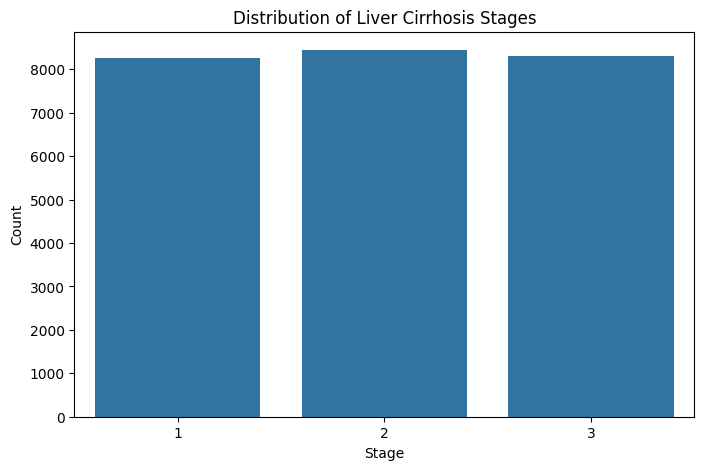

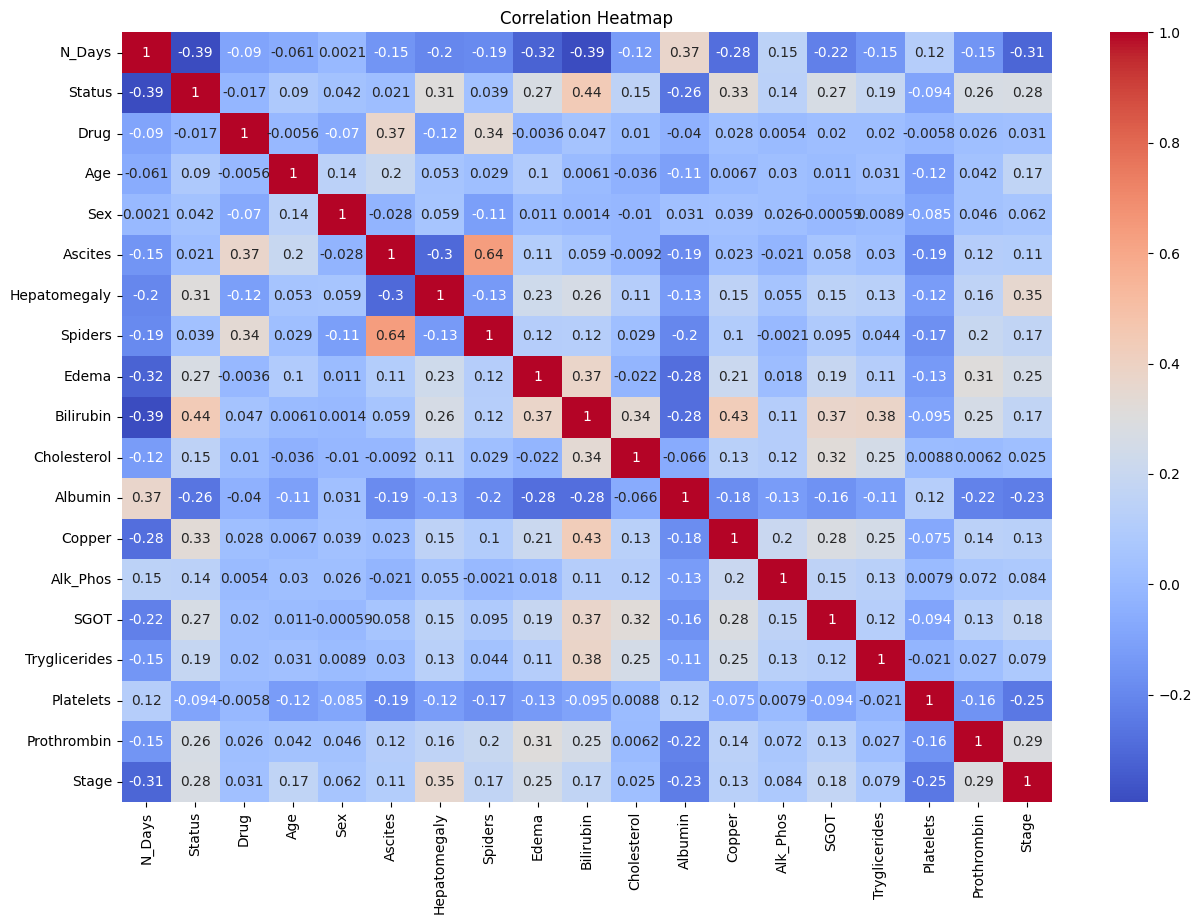

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of the target variable (Stage)
plt.figure(figsize=(8, 5))
sns.countplot(x='Stage', data=ds)
plt.title('Distribution of Liver Cirrhosis Stages')
plt.xlabel('Stage')
plt.ylabel('Count')
plt.show()

# Correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(ds.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [177]:
target = 'Stage'

cont_cols = ds.select_dtypes('number').columns
cont_cols = cont_cols[cont_cols != target]

obj_cols = ds.select_dtypes(object).columns

len(cont_cols), len(obj_cols)

(11, 7)

# 📊 Data Visualization 

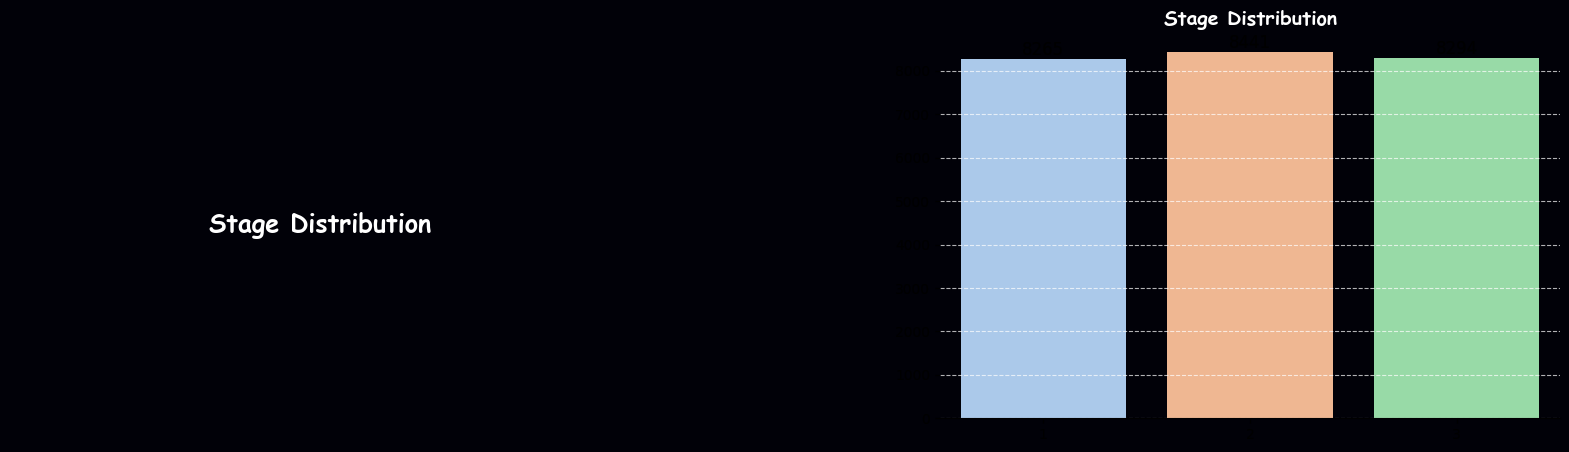

In [178]:
# Create the plot
axes, palette, cb = mPlotter(1, 2, (20, 5), [target], "Stage Distribution")

# Count plot visualization
sns.countplot(x=ds[target], ax=axes[1], hue=ds[target], palette="pastel", legend=False)

# Add count labels on bars
for p in axes[1].containers:
    axes[1].bar_label(p, fmt='%d', label_type='edge', fontsize=12, color='black')

# Enhance aesthetics
axes[1].set_title("Stage Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Stage Levels", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle gridlines

# Apply callback function (if necessary)
cb(axes[1])

# Show plot
plt.show()

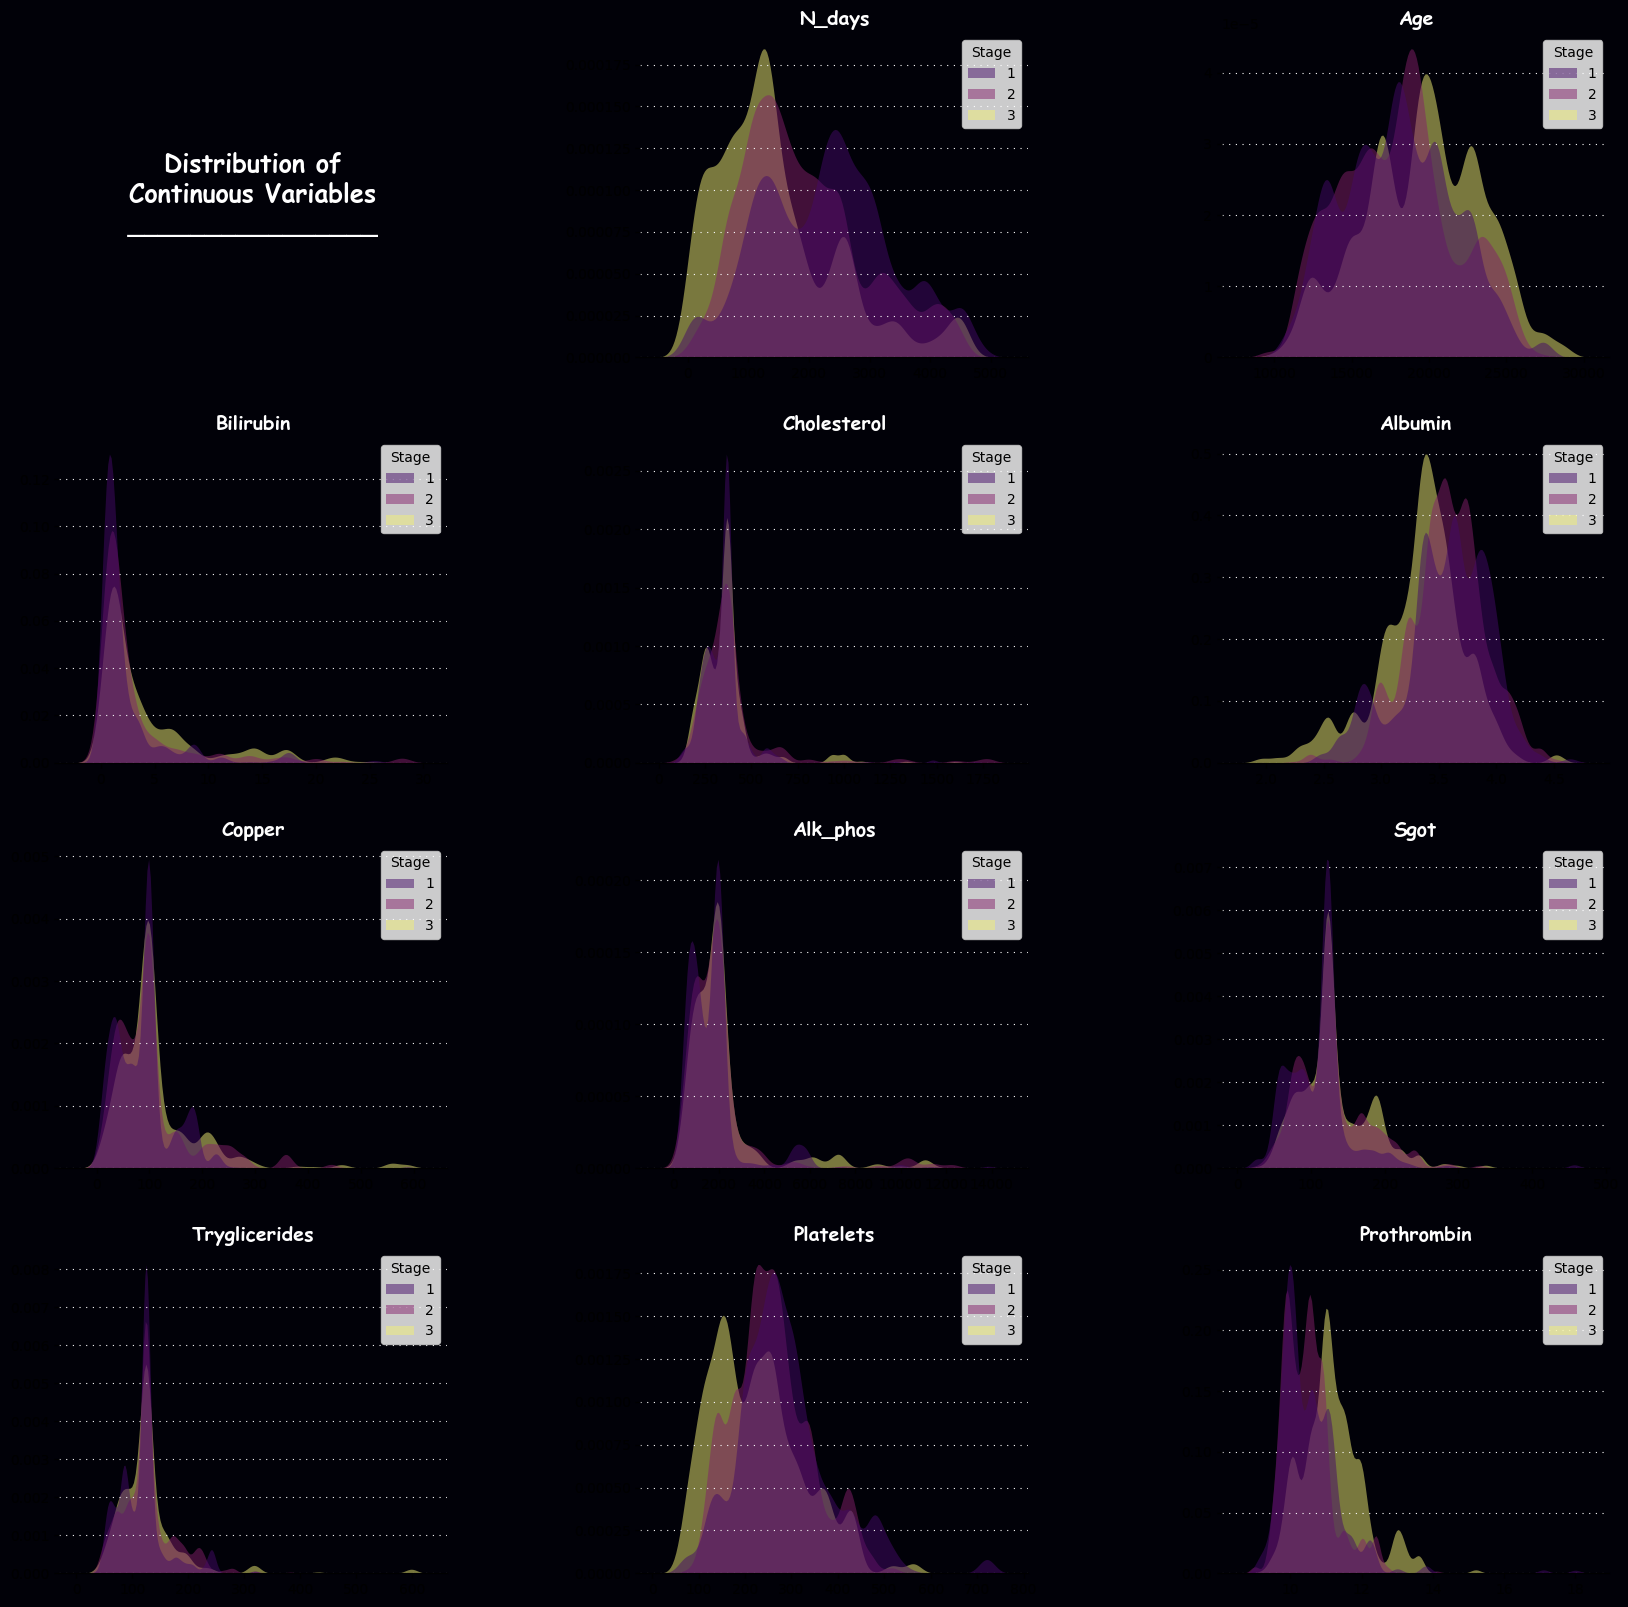

In [179]:
axes, palette, cb = mPlotter(4, 3, (20, 20), cont_cols, 'Distribution of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.kdeplot(data=ds, x=col, ax=ax, hue=target, palette=palette[4:7], alpha=.5, linewidth=0, fill=True)
    cb(ax)

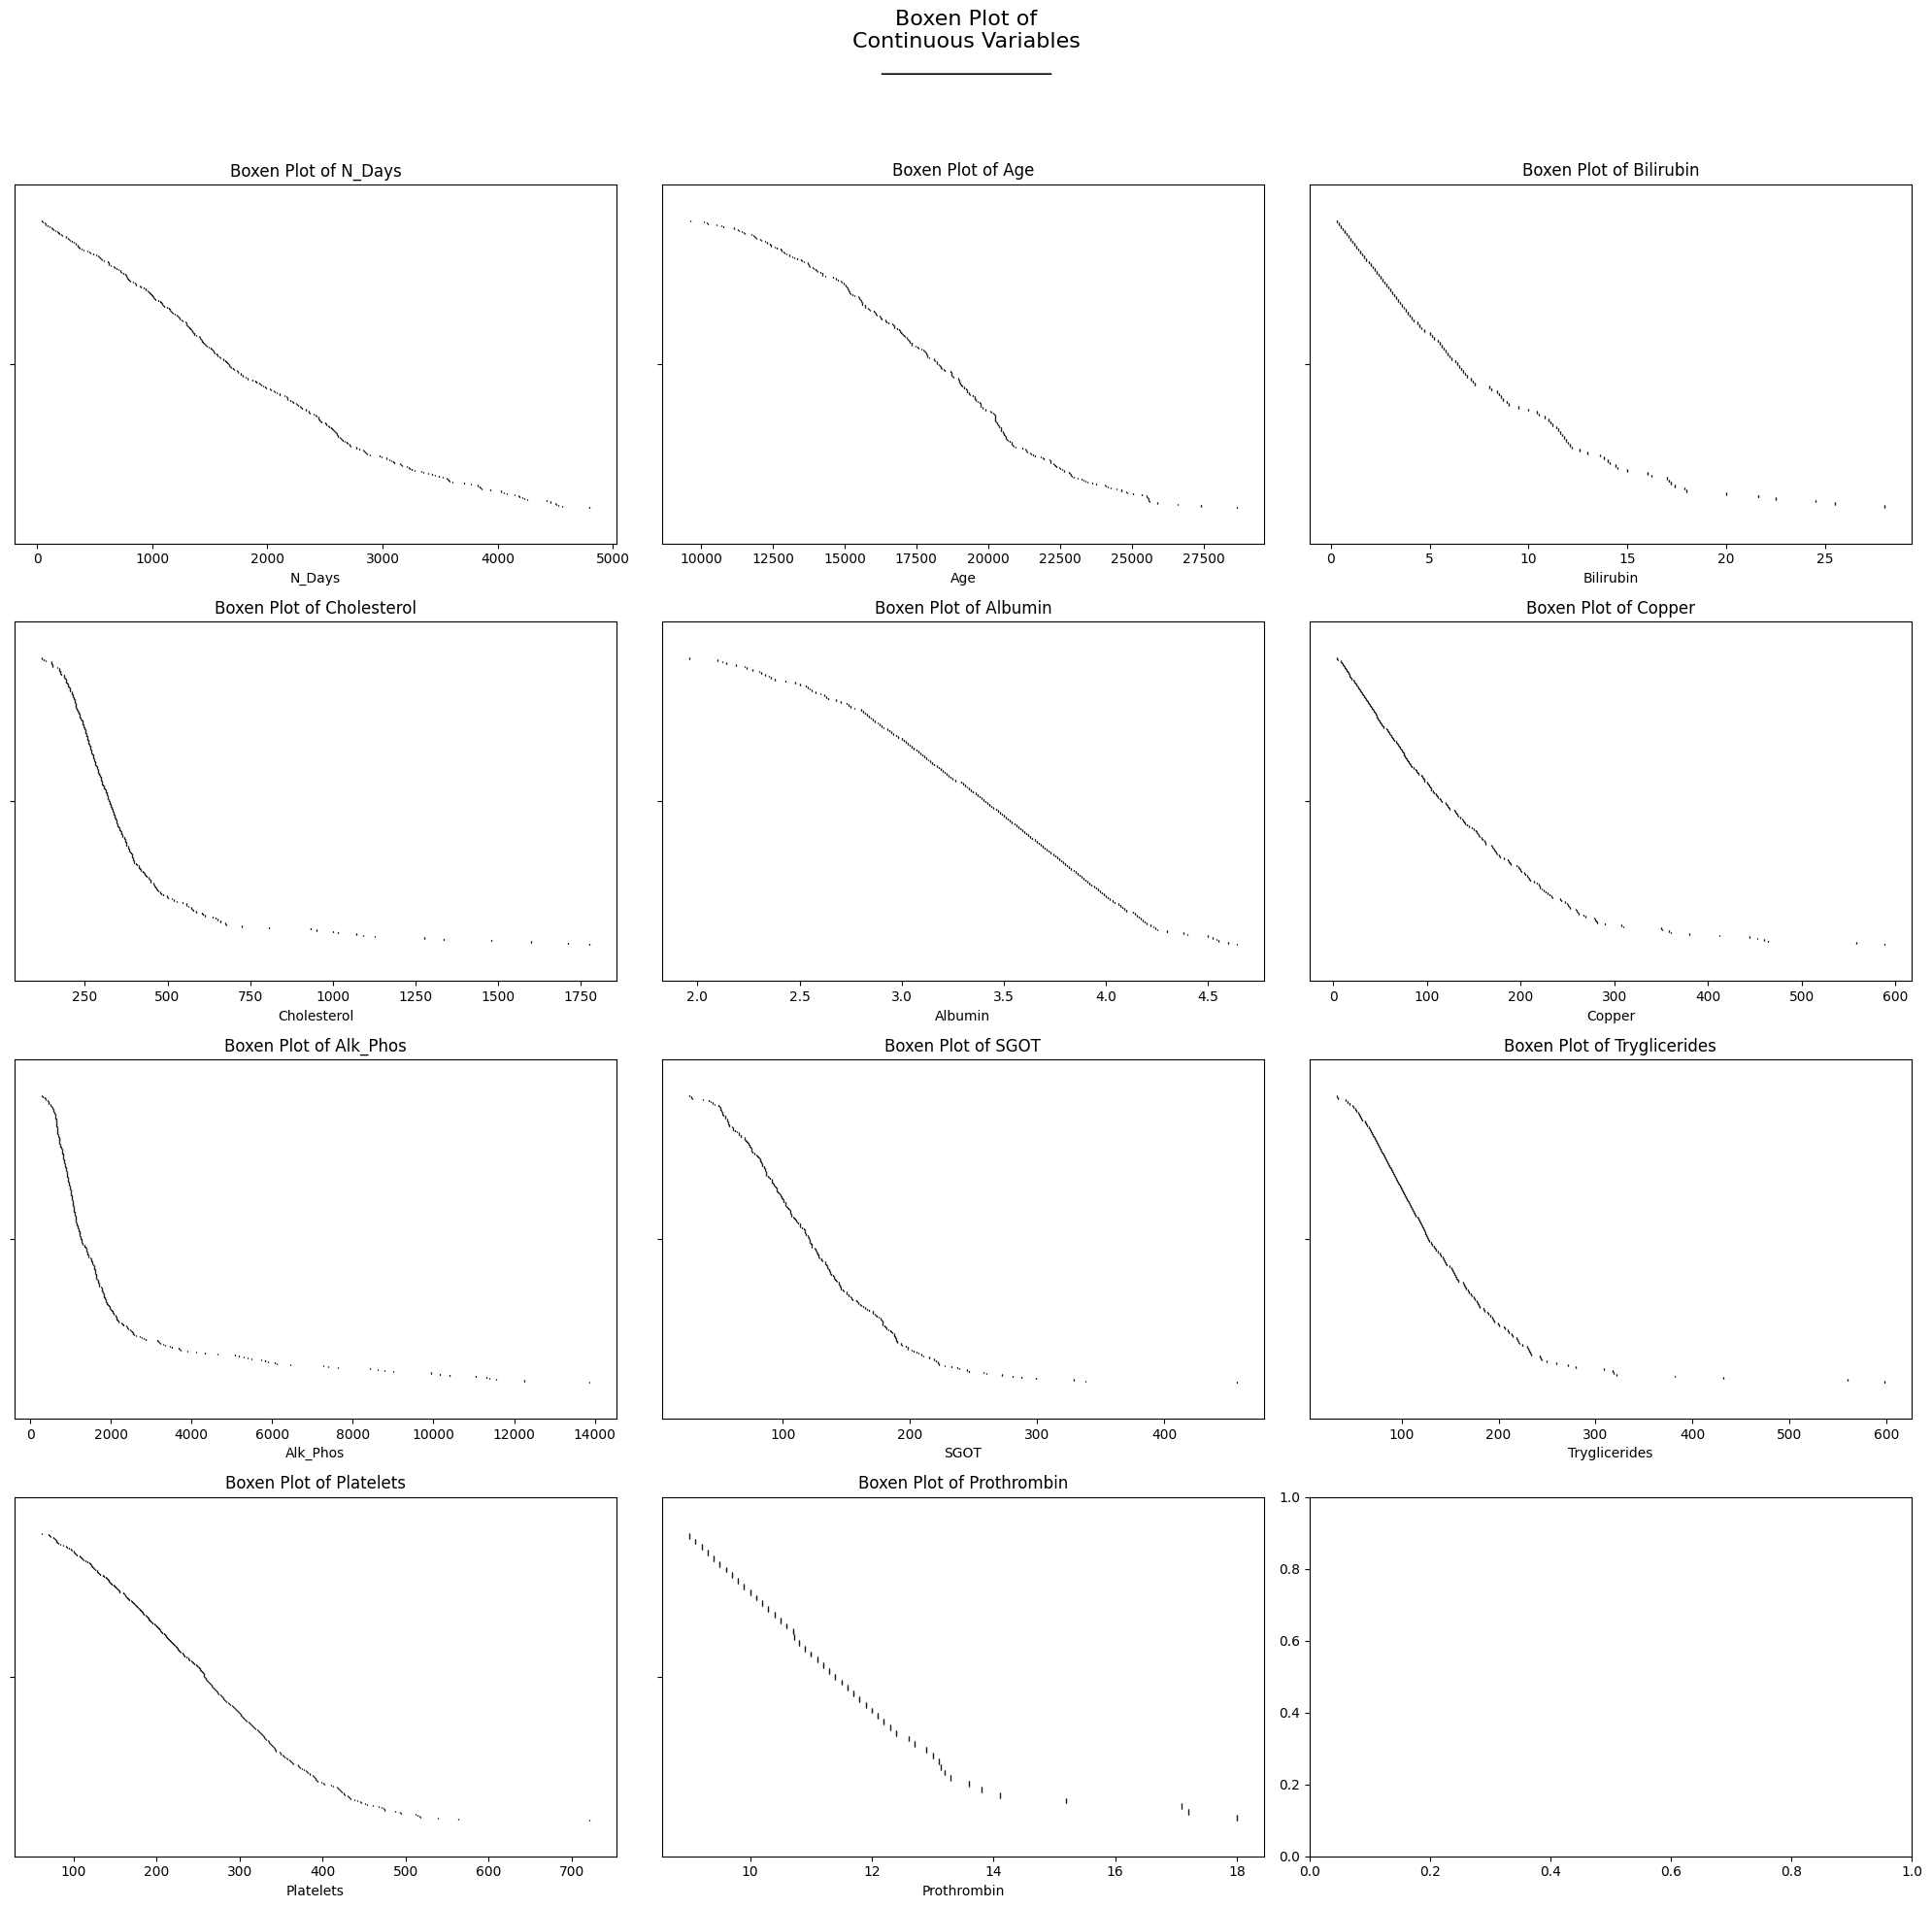

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the function mPlotter to create a figure and axes 
def mPlotter(nrows, ncols, figsize, cols, title):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.suptitle(title, fontsize=16)
    return axes, fig  # Returning only axes and fig (no palette or cb)

# 'cont_cols' are the continuous columns
axes, fig = mPlotter(4, 3, (20, 20), cont_cols, 'Boxen Plot of\nContinuous Variables\n________________')

# Loop through each continuous column and create a boxen plot
for col, ax in zip(cont_cols, axes.flatten()):  # Use flatten to handle 2D array
    sns.boxenplot(data=ds, x=col, ax=ax, hue=col, palette='viridis', legend=False)
    ax.set_title(f'Boxen Plot of {col}')  # Set title for each subplot

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make space for the main title
plt.show()

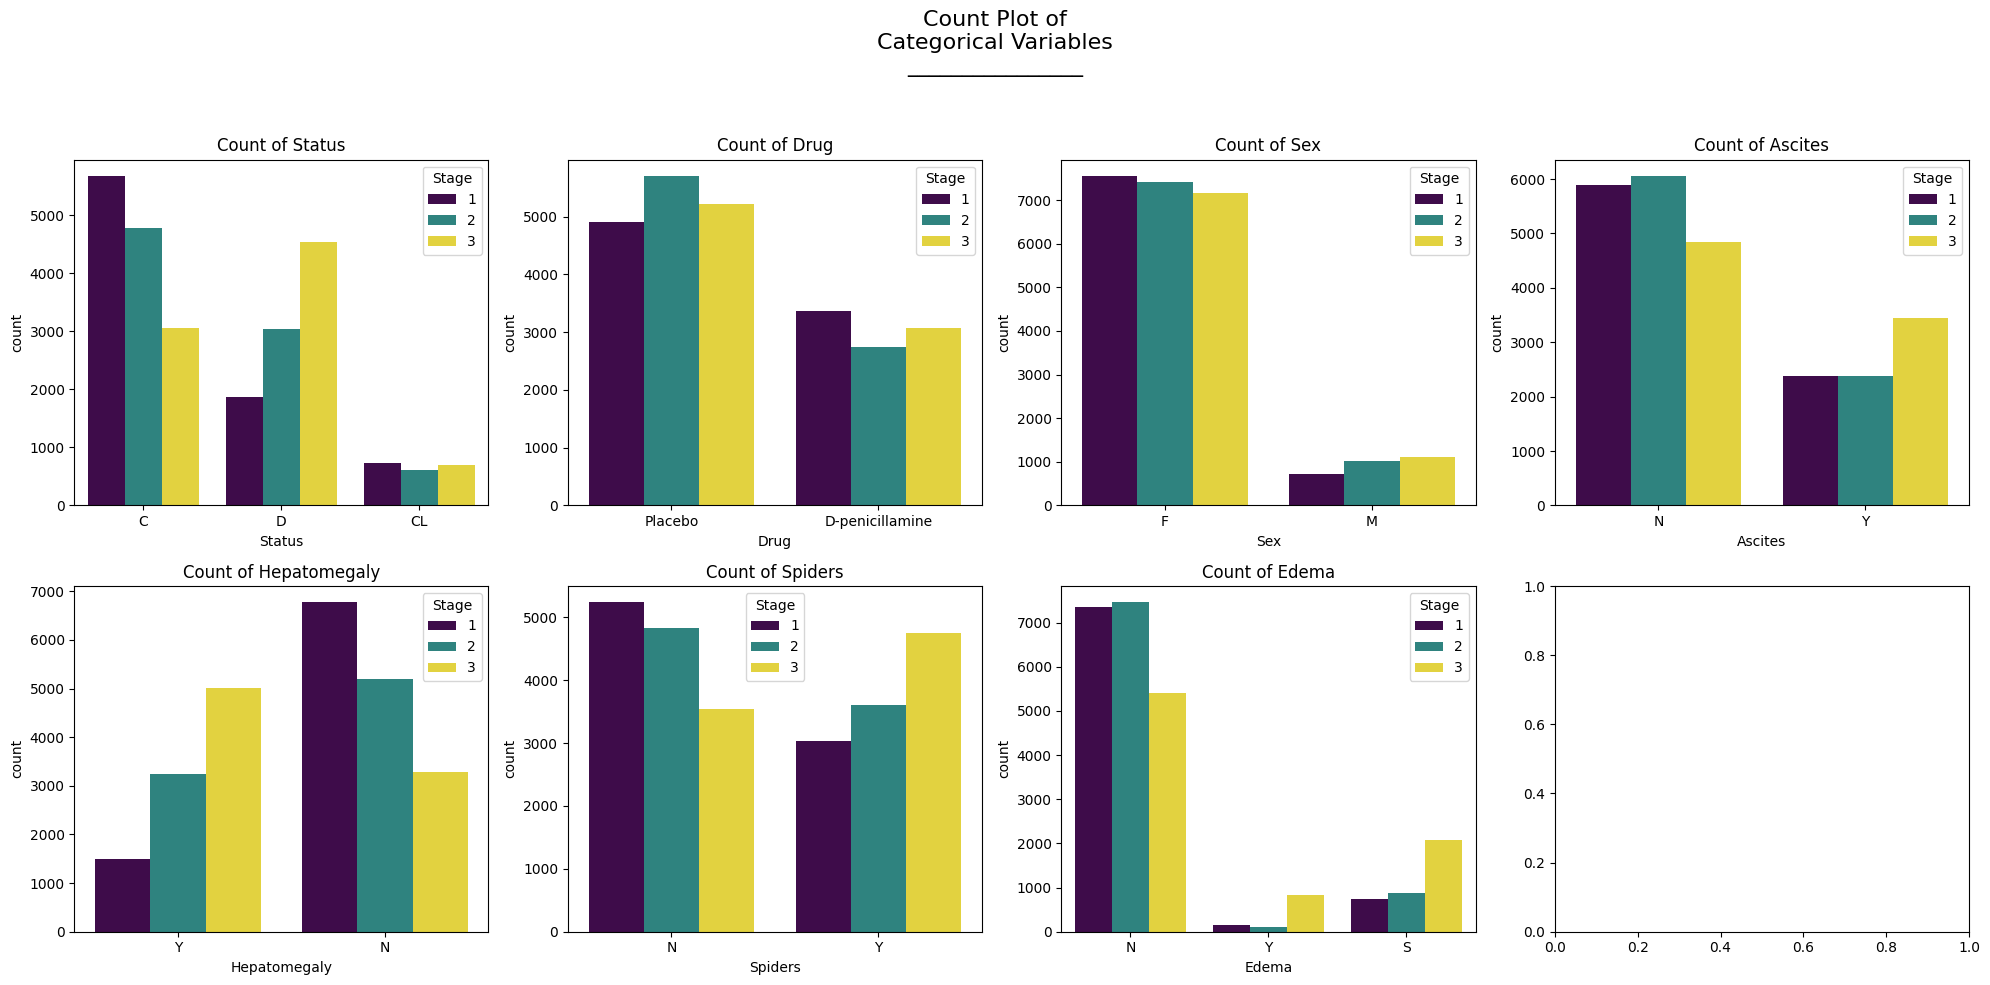

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the function mPlotter to create a figure and axes
def mPlotter(nrows, ncols, figsize, cols, title):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.suptitle(title, fontsize=16)
    return axes, fig

# Create axes for the plots
axes, fig = mPlotter(2, 4, (20, 10), obj_cols, 'Count Plot of\nCategorical Variables\n________________')

# Loop through each column and create a count plot
for col, ax in zip(obj_cols, axes.flatten()):  # Use flatten to handle 2D array
    sns.countplot(data=ds, x=col, ax=ax, hue=target, palette='viridis')  # Use a suitable palette
    ax.set_title(f'Count of {col}')  # Set title for each subplot

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make space for the main title
plt.show()

In [182]:
import plotly.express as px

# Create a 3D scatter plot with a black background
ax = px.scatter_3d(
    ds,
    x="Cholesterol",
    y="Platelets",
    z="N_Days",
    template="plotly_dark",  # Use dark template
    color="Stage"
)

# Update the layout for a black background
ax.update_layout(
    title='3D PLOT',
    title_font=dict(size=20, color='white'),
    plot_bgcolor='black',  # Background color of the plot
    paper_bgcolor='black',  # Background color of the entire figure
    font=dict(color='white'),  # Change font color to white
    
)

# Show the plot
ax.show()

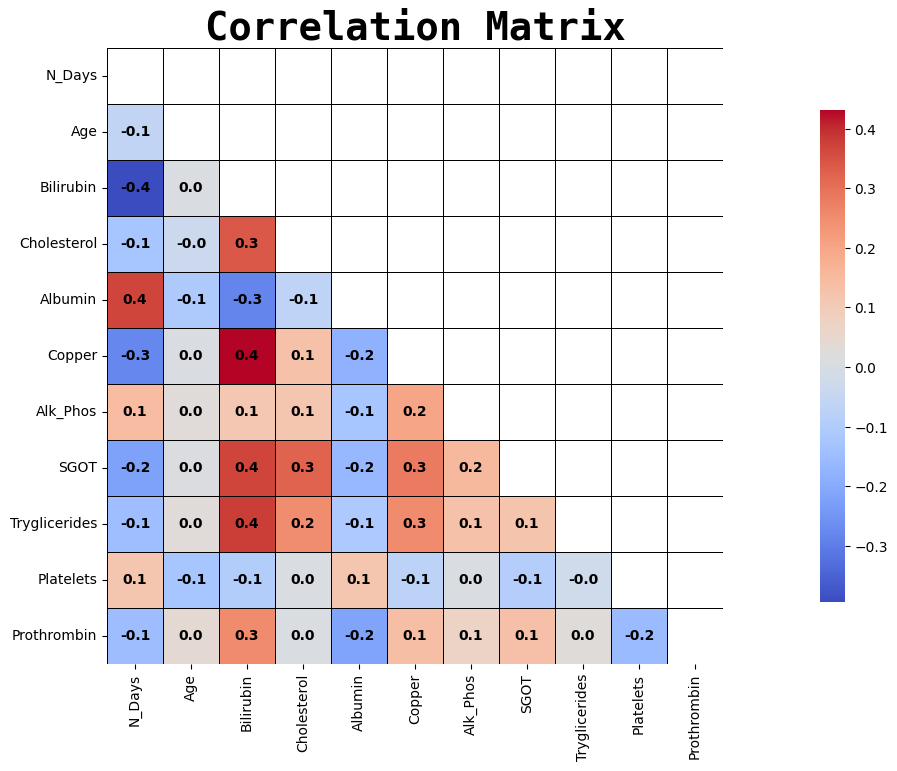

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the figure
fig = plt.figure(figsize=(25, 8))

# Create a gridspec
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.3, hspace=0.15)

# Add a subplot
ax = fig.add_subplot(gs[0, 0])

# Title for the heatmap
ax.set_title("Correlation Matrix", fontsize=28, fontweight='bold', fontfamily='Monospace', color="black")

# Create the heatmap
sns.heatmap(
    ds[cont_cols].corr().transpose(),
    mask=np.triu(np.ones_like(ds[cont_cols].corr().transpose(), dtype=bool)),
    fmt=".1f",
    annot=True,
    cmap='coolwarm',  # Change the colormap for better visual contrast
    cbar=True,  # Show color bar
    cbar_kws={"shrink": 0.8},  # Shrink the color bar
    linewidths=0.5,  # Add lines between cells
    linecolor='black',  # Line color between cells
    square=True,  # Make cells square-shaped
    annot_kws={"size": 10, "weight": "bold", "color": "black"},  # Customize annotation appearance
)

# Show the heatmap
plt.show()

In [7]:
for col in ds.select_dtypes(object):
    ds[col] = LabelEncoder().fit_transform(ds[col])
    
ds

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,0,1,18499,0,0,1,0,0,0.5,149.000000,4.04,227.0,598.0,52.70,57.000000,256.0,9.9,1
1,1230,0,1,19724,1,1,0,1,0,0.5,219.000000,3.93,22.0,663.0,45.00,75.000000,220.0,10.8,2
2,4184,0,1,11839,0,0,0,0,0,0.5,320.000000,3.54,51.0,1243.0,122.45,80.000000,225.0,10.0,2
3,2090,2,1,16467,0,0,0,0,0,0.7,255.000000,3.74,23.0,1024.0,77.50,58.000000,151.0,10.2,2
4,2105,2,1,21699,0,0,1,0,0,1.9,486.000000,3.54,74.0,1052.0,108.50,109.000000,151.0,11.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3584,2,0,23612,0,0,0,0,0,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24996,3584,2,0,23612,0,0,0,0,0,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24997,971,2,0,16736,0,0,1,1,2,5.1,369.510563,3.23,18.0,790.0,179.80,124.702128,104.0,13.0,3
24998,3707,0,0,16990,0,0,1,0,0,0.8,315.000000,4.24,13.0,1637.0,170.50,70.000000,426.0,10.9,2


# Train-Test Split

In [8]:
from sklearn.model_selection import train_test_split

# Features and target variable
X = ds.drop('Stage', axis=1)
y = ds['Stage']

x_train, x_test, y_train, y_test = train_test_split(ds.iloc[:,:-1], ds.iloc[:, -1], random_state=3, train_size=.7)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17500, 18), (17500,), (7500, 18), (7500,))

# Feature Scaling

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = MinMaxScaler().fit_transform(x_train)
x_test = MinMaxScaler().fit_transform(x_test)

# Model Training

In [39]:
# Define the Voting Classifier with individual classifiers
voting_classifier = VotingClassifier(
    estimators=[('cat', CatBoostClassifier(verbose=0)), ('xg', XGBClassifier()), ('lgbm', LGBMClassifier(verbose=-1))],
    voting='soft',
    verbose=False
)

In [40]:
# fit the Voting Classifier to our training data
voting_classifier.fit(x_train, y_train)

VotingClassifier(estimators=[('cat',
                              <catboost.core.CatBoostClassifier object at 0x0000024AF7E33E90>),
                             ('xg',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_polic...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('lgbm', LGBMClassifier(verbose=-1))],
                 voting='soft')

In [41]:
# Make predictions
y_pred = voting_classifier.predict(x_test)

# Model Evaluation

              precision    recall  f1-score   support

           1       0.97      0.95      0.96      2500
           2       0.95      0.96      0.95      2505
           3       0.97      0.97      0.97      2495

    accuracy                           0.96      7500
   macro avg       0.96      0.96      0.96      7500
weighted avg       0.96      0.96      0.96      7500



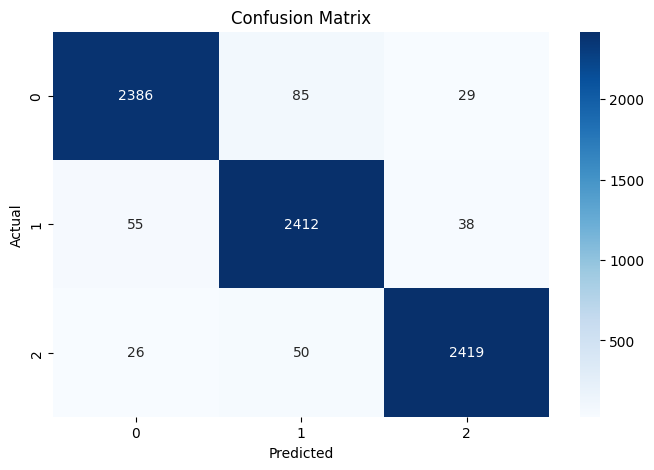

In [42]:
# Generate classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Supervise model performance

In [192]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print (classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.95      0.97      0.96      2467
           2       0.96      0.95      0.95      2547
           3       0.97      0.97      0.97      2486

    accuracy                           0.96      7500
   macro avg       0.96      0.96      0.96      7500
weighted avg       0.96      0.96      0.96      7500



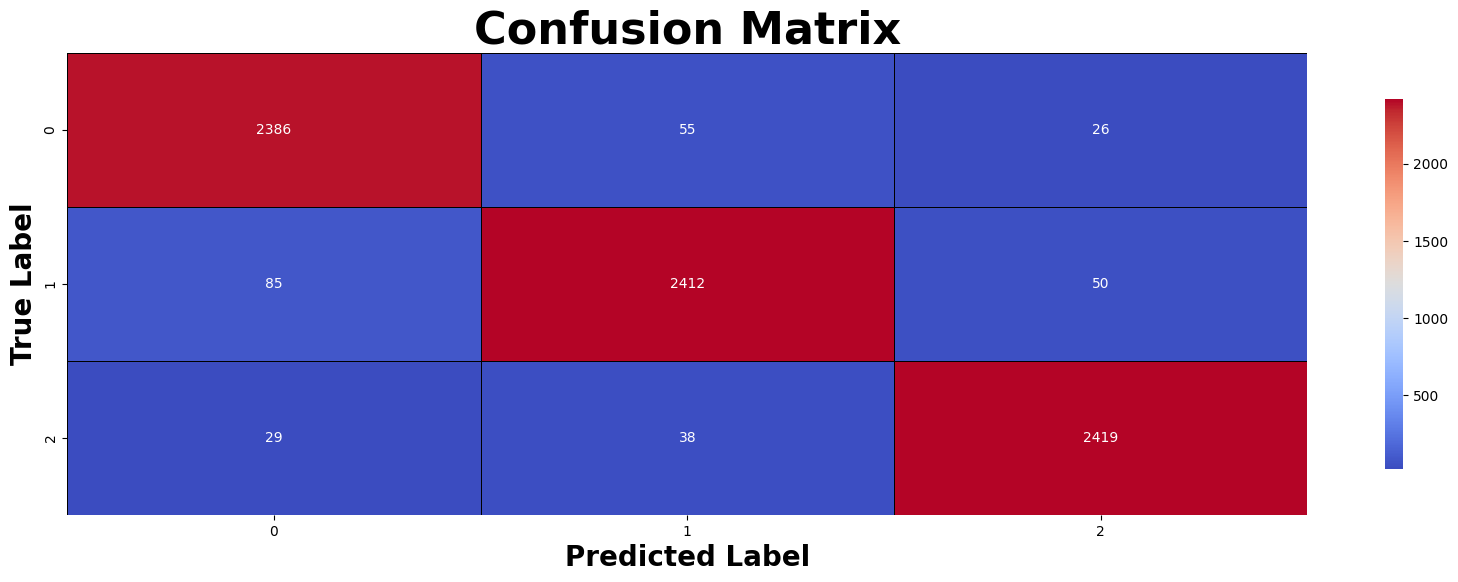

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_pred and y_test are defined
plt.subplots(figsize=(20, 6))

# Create a heatmap with improved aesthetics
sns.heatmap(confusion_matrix(y_pred, y_test), 
            annot=True, 
            fmt="d", 
            cmap="coolwarm",  # Change color palette to coolwarm
            linewidths=.5, 
            linecolor='black',  # Add a border color
            cbar_kws={"shrink": .8})  # Adjust color bar size

plt.title("Confusion Matrix", fontsize=32, fontweight='bold', color="black")  # Title with custom font settings
plt.xlabel("Predicted Label", fontsize=20, fontweight='bold', color="black")  # Custom x-label
plt.ylabel("True Label", fontsize=20, fontweight='bold', color="black")  # Custom y-label

plt.show()
